In [1]:
import string
import torch
import numpy as np

# Define the character vocabulary (printable characters)
CHAR_VOCAB = list(string.ascii_letters + string.digits + string.punctuation)
char2idx = {c: i+1 for i, c in enumerate(CHAR_VOCAB)}  # +1 to reserve 0 for padding
vocab_size = len(char2idx) + 1
max_len = 200  # Max URL length (pad/truncate)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def encode_url(url, max_len=max_len):
    url = url[:max_len].ljust(max_len)  # pad right
    return [char2idx.get(c, 0) for c in url]  # unknown chars as 0


In [2]:
from torch.utils.data import Dataset, DataLoader
import pandas as pd

class URLDataset(Dataset):
    def __init__(self, df):
        self.urls = df['text'].astype(str).values
        self.labels = df['label'].values

    def __len__(self):
        return len(self.urls)

    def __getitem__(self, idx):
        url = self.urls[idx]
        x = torch.tensor(encode_url(url), dtype=torch.long)
        y = torch.tensor(self.labels[idx], dtype=torch.float)
        return x, y


In [3]:
import torch.nn as nn

class CharCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim=64):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)

        self.conv1 = nn.Conv1d(embed_dim, 128, kernel_size=5, padding=2)
        self.relu = nn.ReLU()
        self.pool = nn.AdaptiveMaxPool1d(1)

        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x).permute(0, 2, 1)  # (batch, embed_dim, seq_len)
        x = self.relu(self.conv1(x))
        x = self.pool(x).squeeze(-1)
        x = self.dropout(x)
        return self.sigmoid(self.fc(x)).squeeze()


In [4]:
from tqdm import tqdm
from sklearn.metrics import f1_score
import torch.optim as optim

def train_model(model, train_loader, val_loader, epochs=30, patience=3, lr=1e-3):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=1)

    best_f1 = 0
    patience_counter = 0

    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'f1': [], 'val_f1': [],
        'val_y_true': [], 'val_y_pred': [], 'val_y_prob': []
    }

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        train_preds, train_targets = [], []

        loop = tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]", leave=False)
        for x, y in loop:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * y.size(0)
            preds = (out > 0.5).float()
            train_correct += (preds == y).sum().item()
            train_total += y.size(0)

            train_preds += preds.cpu().numpy().tolist()
            train_targets += y.cpu().numpy().tolist()

            loop.set_postfix(loss=loss.item())

        train_loss /= train_total
        train_acc = train_correct / train_total
        train_f1 = f1_score(train_targets, train_preds)

        # Validation
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        y_true, y_pred, y_prob = [], [], []

        loop = tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]", leave=False)
        with torch.no_grad():
            for x, y in loop:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)

                val_loss += loss.item() * y.size(0)
                probs = out.cpu()
                preds = (probs > 0.5).float()

                val_correct += (preds == y.cpu()).sum().item()
                val_total += y.size(0)

                y_prob += probs.numpy().tolist()
                y_pred += preds.numpy().tolist()
                y_true += y.cpu().numpy().tolist()

        val_loss /= val_total
        val_acc = val_correct / val_total
        val_f1 = f1_score(y_true, y_pred)

        # Save history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['f1'].append(train_f1)
        history['val_f1'].append(val_f1)
        history['val_y_true'] = y_true
        history['val_y_pred'] = y_pred
        history['val_y_prob'] = y_prob

        print(f"\nEpoch {epoch+1}: "
              f"Train Loss={train_loss:.4f}, Acc={train_acc:.4f}, F1={train_f1:.4f} | "
              f"Val Loss={val_loss:.4f}, Acc={val_acc:.4f}, F1={val_f1:.4f}")

        scheduler.step(val_f1)

        if val_f1 > best_f1:
            best_f1 = val_f1
            patience_counter = 0
            torch.save(model.state_dict(), "best_charcnn.pt")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    return history


In [5]:
from matplotlib import pyplot as plt
def plot_loss(history):
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_accuracy(history):
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Val Accuracy')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [6]:
def plot_f1_curve(history):
    plt.plot(history['f1'], label='Train F1')
    plt.plot(history['val_f1'], label='Val F1')
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.title("Training vs Validation F1 Score")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Legit', 'Phishing'], yticklabels=['Legit', 'Phishing'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()


In [8]:
from sklearn.metrics import roc_curve, auc
def plot_roc_curve(y_true, y_prob):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.tight_layout()
    plt.show()



Epoch 1: Train Loss=0.1563, Acc=0.9409, F1=0.9362 | Val Loss=0.1044, Acc=0.9613, F1=0.9579



Epoch 2: Train Loss=0.1187, Acc=0.9563, F1=0.9530 | Val Loss=0.0921, Acc=0.9668, F1=0.9643



Epoch 3: Train Loss=0.1094, Acc=0.9598, F1=0.9567 | Val Loss=0.0880, Acc=0.9690, F1=0.9666



Epoch 4: Train Loss=0.1042, Acc=0.9618, F1=0.9590 | Val Loss=0.0866, Acc=0.9692, F1=0.9670



Epoch 5: Train Loss=0.1002, Acc=0.9634, F1=0.9607 | Val Loss=0.0832, Acc=0.9706, F1=0.9685



Epoch 6: Train Loss=0.0977, Acc=0.9645, F1=0.9618 | Val Loss=0.0958, Acc=0.9646, F1=0.9611



Epoch 7: Train Loss=0.0957, Acc=0.9651, F1=0.9625 | Val Loss=0.0804, Acc=0.9714, F1=0.9693



Epoch 8: Train Loss=0.0938, Acc=0.9658, F1=0.9632 | Val Loss=0.0861, Acc=0.9699, F1=0.9681



Epoch 9: Train Loss=0.0922, Acc=0.9665, F1=0.9640 | Val Loss=0.0788, Acc=0.9722, F1=0.9702



Epoch 10: Train Loss=0.0909, Acc=0.9669, F1=0.9644 | Val Loss=0.0783, Acc=0.9727, F1=0.9708



Epoch 11: Train Loss=0.0897, Acc=0.9673, F1=0.9649 | Val Loss=0.0784, Acc=0.9727, F1=0.9708



Epoch 12: Train Loss=0.0889, Acc=0.9677, F1=0.9653 | Val Loss=0.0774, Acc=0.9731, F1=0.9711



Epoch 13: Train Loss=0.0879, Acc=0.9682, F1=0.9659 | Val Loss=0.0783, Acc=0.9728, F1=0.9710



Epoch 14: Train Loss=0.0866, Acc=0.9686, F1=0.9662 | Val Loss=0.0766, Acc=0.9729, F1=0.9707



Epoch 15: Train Loss=0.0812, Acc=0.9706, F1=0.9684 | Val Loss=0.0723, Acc=0.9745, F1=0.9725



Epoch 16: Train Loss=0.0793, Acc=0.9715, F1=0.9694 | Val Loss=0.0724, Acc=0.9751, F1=0.9733



Epoch 17: Train Loss=0.0791, Acc=0.9712, F1=0.9691 | Val Loss=0.0725, Acc=0.9748, F1=0.9729



Epoch 18: Train Loss=0.0791, Acc=0.9712, F1=0.9691 | Val Loss=0.0719, Acc=0.9747, F1=0.9728



Epoch 19: Train Loss=0.0756, Acc=0.9725, F1=0.9705 | Val Loss=0.0707, Acc=0.9760, F1=0.9743



Epoch 20: Train Loss=0.0752, Acc=0.9726, F1=0.9706 | Val Loss=0.0701, Acc=0.9757, F1=0.9739



Epoch 21: Train Loss=0.0744, Acc=0.9730, F1=0.9710 | Val Loss=0.0709, Acc=0.9758, F1=0.9741



Epoch 22: Train Loss=0.0729, Acc=0.9737, F1=0.9717 | Val Loss=0.0693, Acc=0.9761, F1=0.9744



Epoch 23: Train Loss=0.0728, Acc=0.9736, F1=0.9716 | Val Loss=0.0698, Acc=0.9758, F1=0.9739



Epoch 24: Train Loss=0.0719, Acc=0.9741, F1=0.9722 | Val Loss=0.0691, Acc=0.9757, F1=0.9739



Epoch 25: Train Loss=0.0714, Acc=0.9741, F1=0.9722 | Val Loss=0.0690, Acc=0.9761, F1=0.9743
Early stopping triggered.


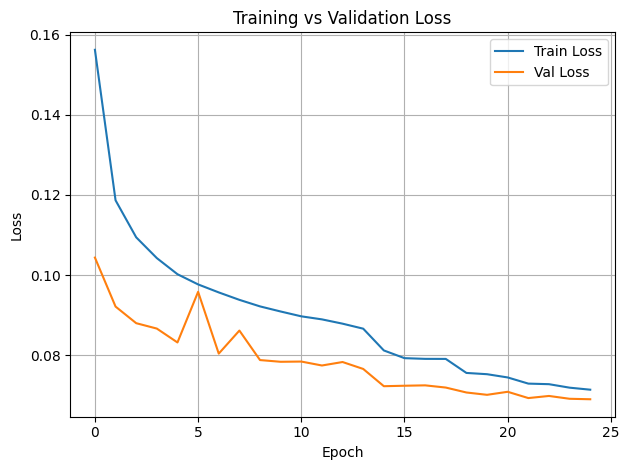

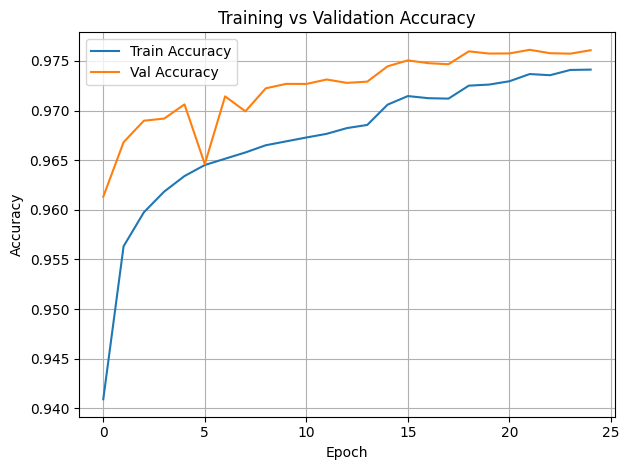

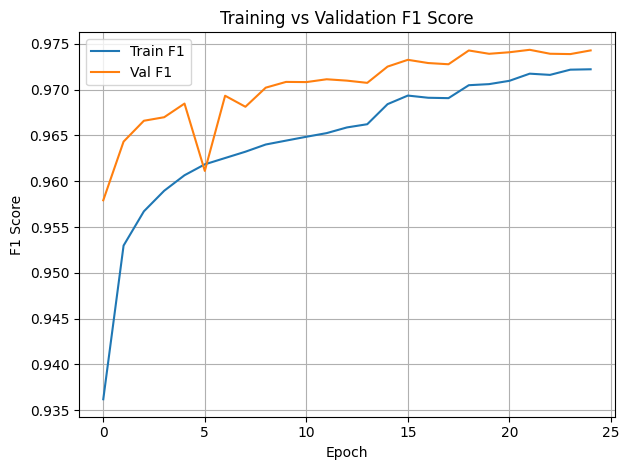

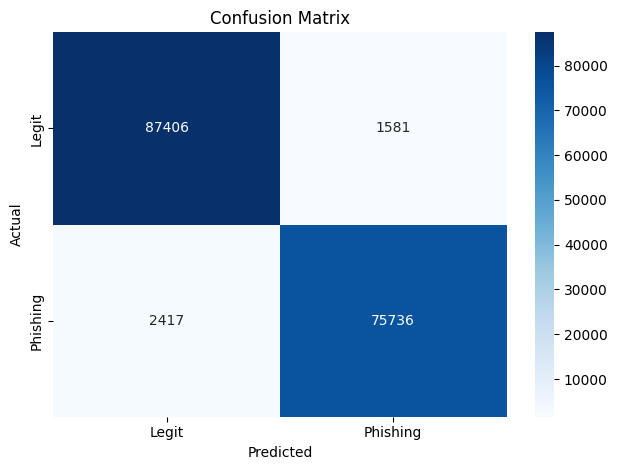

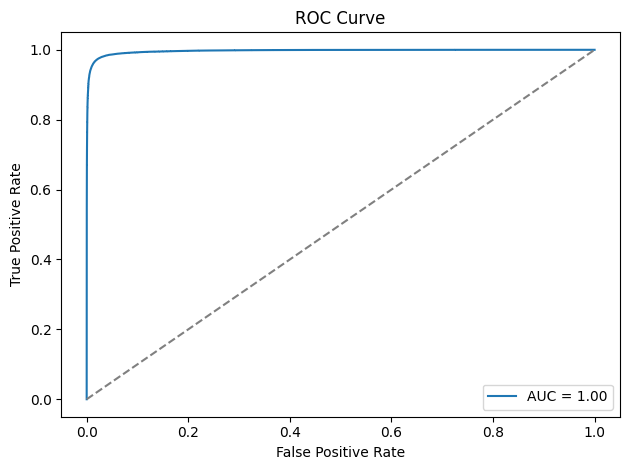

In [9]:
from sklearn.model_selection import train_test_split

# Load your data
df = pd.read_json(r"E:\Phising_detection\dataset\urls\urls.json")
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# Create datasets and loaders
train_set = URLDataset(train_df)
val_set = URLDataset(val_df)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64)

# Train model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CharCNN(vocab_size).to(device)


# Train model
history = train_model(model, train_loader, val_loader)

# Plot all metrics
plot_loss(history)
plot_accuracy(history)
plot_f1_curve(history)
plot_confusion_matrix(history['val_y_true'], history['val_y_pred'])
plot_roc_curve(history['val_y_true'], history['val_y_prob'])


In [10]:
import json

with open("vocab_char.json", "w") as f:
        json.dump(char2idx, f)